In [1]:
import os
import cv2
import imghdr
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split

C:\Users\user\AppData\Local\Temp\ipykernel_39756\1228204448.py:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


# Cleaning Images

In [2]:
data_dir = 'Images/'

In [3]:
image_extensions = ['jpg', 'jpeg', 'png', 'bmp']

In [5]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            image_type = imghdr.what(image_path)
            if image_type not in image_extensions:
                print(f'{image_path} is not a valid image')
                os.remove(image_path)
        except Exception as e:
            print(f'Error processing {image_path}: {e}')

# Data Preprocessing

In [6]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 4589 files belonging to 14 classes.


In [7]:
data_iterators = data.as_numpy_iterator()
batch = next(data_iterators)
batch[1].max()


np.int32(13)

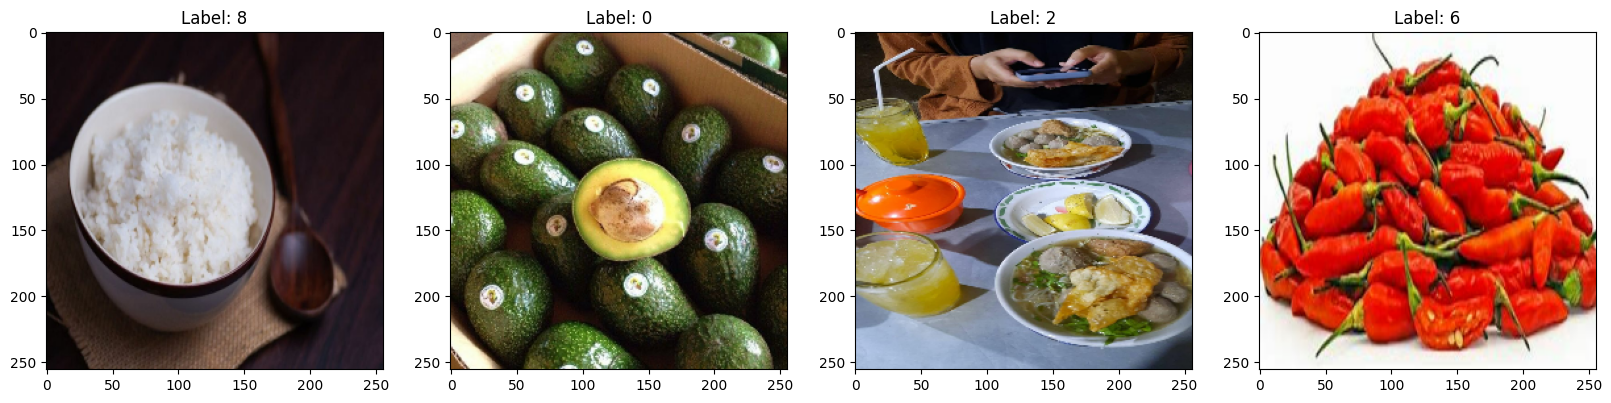

In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, image in enumerate(batch[0][:4]):
    ax[idx].imshow(image.astype(int))
    ax[idx].title.set_text(f'Label: {batch[1][idx]}')

In [9]:
data_dir_path = Path(data_dir)
filepaths = list(data_dir_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(250, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [10]:
image_df['Label'].value_counts()

Label
Bawang Putih       250
Bawang Bombai      250
Telur Mata Sapi    250
Cabe Rawit         250
Sate Ayam          250
Tempe Goreng       250
Ayam Goreng        250
Pisang             250
Nasi Putih         250
Bakso              250
Alpukat            250
Mangga             250
Tahu Goreng        250
Bawang Merah       250
Name: count, dtype: int64

Split Data

In [22]:
train_df, test_df = train_test_split(
    image_df, 
    train_size=0.8, 
    shuffle=True, 
    random_state=1)

In [23]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [24]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2240 validated image filenames belonging to 14 classes.
Found 560 validated image filenames belonging to 14 classes.
Found 700 validated image filenames belonging to 14 classes.


# Pre-Trained

In [72]:
res_base = tf.keras.applications.ResNet152V2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
res_base.trainable = False

inputs = res_base.input

x = res_base(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(14, activation = 'sigmoid')(x)
model = tf.keras.Model(inputs, outputs)
print(model.summary())

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 7, 7, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 14)             │        14,350 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,444,174 (230.58 MB)

 Trainable params: 2,112,526 (8.06 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

None


# Training

In [73]:
from tensorflow.keras.optimizers import Adamax

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [74]:
# Define callbacks for early stopping and model checkpoint
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model with frozen layers
history1 = model.fit(train_images, epochs=30, verbose=1, validation_data=val_images, callbacks=callbacks, shuffle=False)

Epoch 1/30
21/70 ━━━━━━━━━━━━━━━━━━━━ 4:55 6s/step - accuracy: 0.3627 - loss: 2.2441

c:\Users\user\Downloads\Smartbite\.conda\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5478 - loss: 1.5287
Epoch 1: val_loss improved from inf to 0.43890, saving model to best_model.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 579s 8s/step - accuracy: 0.5499 - loss: 1.5214 - val_accuracy: 0.8625 - val_loss: 0.4389
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8689 - loss: 0.4015
Epoch 2: val_loss improved from 0.43890 to 0.38449, saving model to best_model.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 559s 8s/step - accuracy: 0.8689 - loss: 0.4013 - val_accuracy: 0.8821 - val_loss: 0.3845
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9165 - loss: 0.2761
Epoch 3: val_loss improved from 0.38449 to 0.36141, saving model to best_model.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 572s 8s/step - accuracy: 0.9165 - loss: 0.2759 - val_accuracy: 0.8875 - val_loss: 0.3614
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9440 - loss: 0.1981
Epoch 4: val_loss improved from 0.36141 to 0.34588, saving model to best_model.k

KeyboardInterrupt: 

In [80]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

c:\Users\user\Downloads\Smartbite\.conda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\user\Downloads\Smartbite\.conda\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Test Accuracy: 89.00%


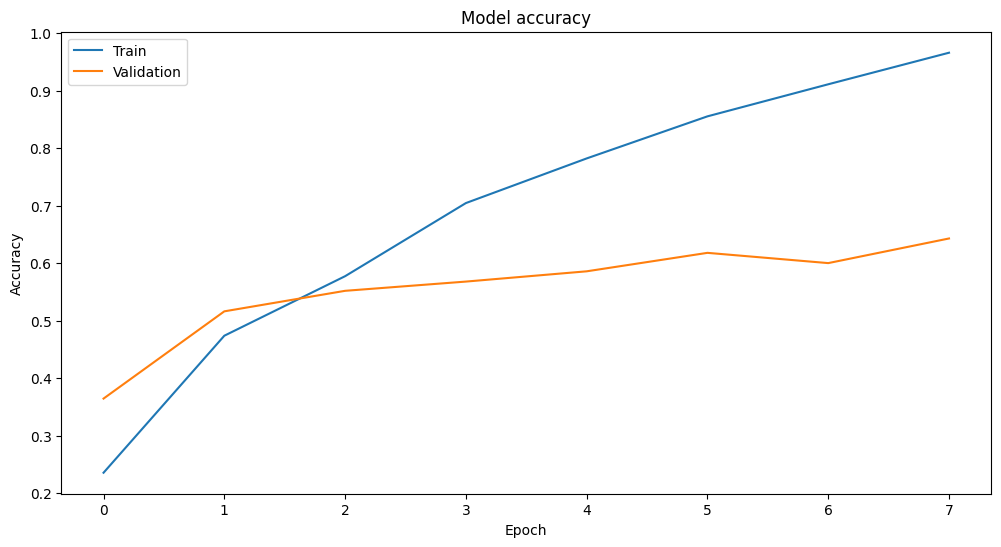

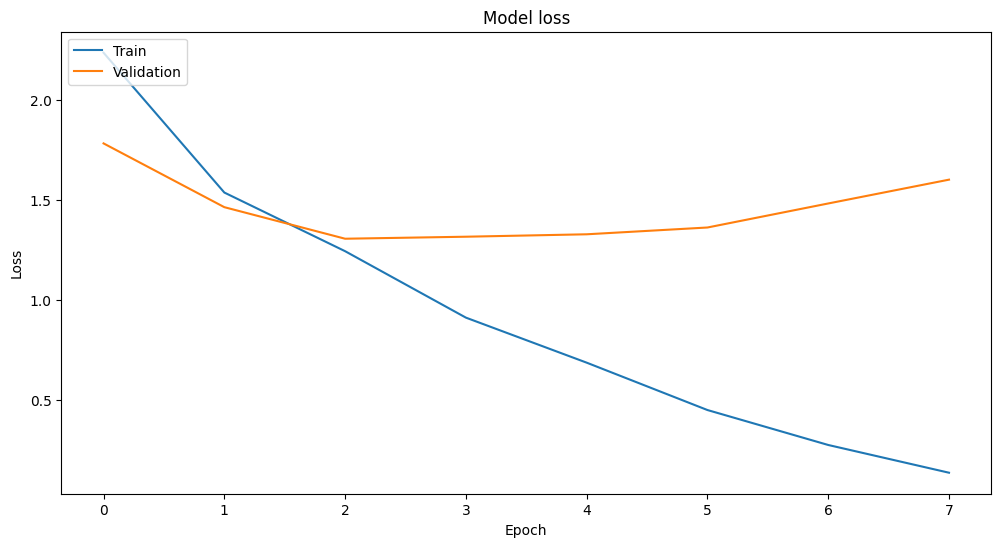

In [81]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Prediction

In [84]:
csv_path = 'Data/nutrition.csv'
def load_nutrition_data(csv_path: str) -> pd.DataFrame:

    return pd.read_csv(csv_path)

def get_nutrition_info(food_name: str, nutrition_data: pd.DataFrame) -> dict:

    match = nutrition_data[nutrition_data['name'].str.lower() == food_name.lower()]
    if not match.empty:
        return {
            'Calories (per 100g)': match['calories'].values[0],
            'Protein (per 100g)': match['proteins'].values[0],
            'Fat (per 100g)': match['fat'].values[0],
            'Carbohydrate (per 100g)': match['carbohydrate'].values[0]
        }
    return None

In [86]:
def predict_food(image_path, model_path, csv_path, class_indices):
    model = tf.keras.models.load_model(model_path)
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)
    predicted_class = np.argmax(prediction, axis=1)[0]

    class_names = {v: k for k, v in class_indices.items()}
    food_name = class_names[predicted_class]

    nutrition_data = load_nutrition_data(csv_path)
    nutrition_info = get_nutrition_info(food_name, nutrition_data)

    if nutrition_info:
        return f"Food: {food_name}\nNutrition per 100g:\n" + "\n".join(
            [f"{key}: {value}" for key, value in nutrition_info.items()]
        )
    return f"Food: {food_name}\nNutrition data not found."

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Food: Bawang Merah
Nutrition per 100g:
Calories (per 100g): 42
Protein (per 100g): 0.9
Fat (per 100g): 0.08
Carbohydrate (per 100g): 10.1


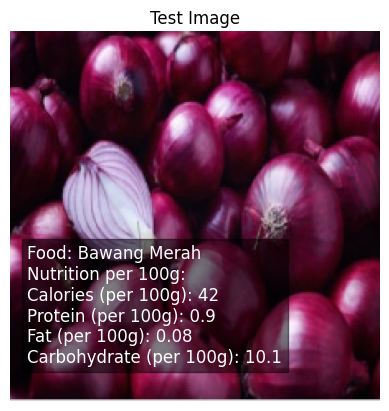

In [90]:
csv_path = 'Data/nutrition.csv'
model_path = 'best_model.keras'
test_image_path = 'bm.jpeg'

# Step 3: Predict on a sample image
result = predict_food(test_image_path, model_path, csv_path, train_images.class_indices)

print(result)
# Show the image using matplotlib
img = tf.keras.preprocessing.image.load_img(test_image_path, target_size=(224, 224))
# Add the nutrition information text inside the image
plt.imshow(img)
plt.title("Test Image")
plt.axis('off')

# Add text to the image
nutrition_text = result.replace('\n', '\n')
plt.text(10, 200, nutrition_text, fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.5))

plt.show()